# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
# class Config():
#     training_dir = "./dataset/db_periocular/train"
#     train_batch_size = 64
#     train_number_epochs = 300
#     testing_dir = "./dataset/db_periocular/test"

class Config():
    training_dir = "./dataset/db_cropped_face/train"
    train_batch_size = 64
    train_number_epochs = 300
    testing_dir = "./dataset/db_cropped_face/test"

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print (img0_tuple[1]) : folder name
        #we need to make sure approx 50% of images are in the same class
        #print ("img0 ",img0_tuple[0], img0_tuple[1])
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                
                if ((img0_tuple[1]==img1_tuple[1]) and (img0_tuple[0] != img1_tuple[0])):
                    #print ("img1 ", img1_tuple[0], "genuine", img1_tuple[1])
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                
                if img0_tuple[1] !=img1_tuple[1]:
                    #print ("img1 ", img1_tuple[0],"imposter",img1_tuple[1])
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        img0_folder=os.path.dirname(img0_tuple[0])[-4:]
        img1_folder=os.path.dirname(img1_tuple[0])[-4:]
        
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)) , img0_folder, img1_folder, img0_tuple[0],img1_tuple[0]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
import os
__file__="./dataset/db_periocular/train/0023/23_1_resized.jpg"

print(os.path.dirname(__file__)[-4:])

0023


## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

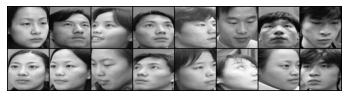

위 폴더 ('0483', '0864', '0354', '0865', '0708', '0687', '0053', '0882')
아래 폴더 ('0589', '0339', '0622', '0865', '0358', '0169', '0189', '0882')
Imposter matching [1.]
Imposter matching [1.]
Imposter matching [1.]
genuine matching [0.]
Imposter matching [1.]
Imposter matching [1.]
Imposter matching [1.]
genuine matching [0.]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

#imshow(torch.cat((example_batch[0],example_batch[1]),0))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

print ("위 폴더", example_batch[3])
print ("아래 폴더", example_batch[4])

for i in example_batch[2].numpy():
    if i == 1 : 
        print ("Imposter matching",i)
    else:
        print ("genuine matching", i)
#print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [15]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
# optimizer = optim.RMSprop(net.parameters(), lr=1e-4)
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9)

In [16]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.171828031539917

Epoch number 0
 Current loss 1.638472557067871

Epoch number 0
 Current loss 1.703342080116272

Epoch number 0
 Current loss 1.463961124420166

Epoch number 0
 Current loss 1.583254098892212

Epoch number 0
 Current loss 1.359518051147461

Epoch number 0
 Current loss 1.242957592010498

Epoch number 0
 Current loss 1.142043113708496

Epoch number 0
 Current loss 0.9624372720718384

Epoch number 0
 Current loss 1.0780160427093506

Epoch number 0
 Current loss 1.1359150409698486

Epoch number 0
 Current loss 1.118998646736145

Epoch number 0
 Current loss 1.097602367401123

Epoch number 0
 Current loss 1.1406323909759521

Epoch number 0
 Current loss 0.9557847380638123

Epoch number 0
 Current loss 1.0723837614059448

Epoch number 0
 Current loss 0.8974999189376831

Epoch number 0
 Current loss 1.0852954387664795

Epoch number 0
 Current loss 1.1254771947860718

Epoch number 0
 Current loss 1.023519515991211

Epoch number 0
 Current loss 1.

Epoch number 5
 Current loss 0.5745526552200317

Epoch number 5
 Current loss 0.4707568287849426

Epoch number 5
 Current loss 0.5668611526489258

Epoch number 5
 Current loss 0.7170727252960205

Epoch number 5
 Current loss 0.7558708786964417

Epoch number 5
 Current loss 0.569773256778717

Epoch number 5
 Current loss 0.7873885035514832

Epoch number 5
 Current loss 0.8496533632278442

Epoch number 5
 Current loss 0.789384126663208

Epoch number 5
 Current loss 0.5021495819091797

Epoch number 5
 Current loss 0.5264049768447876

Epoch number 5
 Current loss 0.4998771846294403

Epoch number 5
 Current loss 0.41297397017478943

Epoch number 5
 Current loss 0.6918196678161621

Epoch number 5
 Current loss 0.5188723802566528

Epoch number 5
 Current loss 0.47123050689697266

Epoch number 5
 Current loss 0.6426109075546265

Epoch number 5
 Current loss 0.5513389110565186

Epoch number 6
 Current loss 0.6057411432266235

Epoch number 6
 Current loss 0.5119008421897888

Epoch number 6
 Curr

Epoch number 10
 Current loss 0.4966592788696289

Epoch number 10
 Current loss 0.6106484532356262

Epoch number 10
 Current loss 0.47385257482528687

Epoch number 10
 Current loss 0.4194311797618866

Epoch number 10
 Current loss 0.45240283012390137

Epoch number 10
 Current loss 0.5432431697845459

Epoch number 11
 Current loss 0.43971917033195496

Epoch number 11
 Current loss 0.49863100051879883

Epoch number 11
 Current loss 0.5826326608657837

Epoch number 11
 Current loss 0.4077039361000061

Epoch number 11
 Current loss 0.5020208358764648

Epoch number 11
 Current loss 0.4028084874153137

Epoch number 11
 Current loss 0.40224963426589966

Epoch number 11
 Current loss 0.41349339485168457

Epoch number 11
 Current loss 0.44844621419906616

Epoch number 11
 Current loss 0.41778263449668884

Epoch number 11
 Current loss 0.5296415090560913

Epoch number 11
 Current loss 0.5330052971839905

Epoch number 11
 Current loss 0.43749773502349854

Epoch number 11
 Current loss 0.428856074

Epoch number 16
 Current loss 0.42067667841911316

Epoch number 16
 Current loss 0.49037599563598633

Epoch number 16
 Current loss 0.5494498014450073

Epoch number 16
 Current loss 0.40490293502807617

Epoch number 16
 Current loss 0.3717809021472931

Epoch number 16
 Current loss 0.46629881858825684

Epoch number 16
 Current loss 0.37426871061325073

Epoch number 16
 Current loss 0.2780701518058777

Epoch number 16
 Current loss 0.49862349033355713

Epoch number 16
 Current loss 0.4212906062602997

Epoch number 16
 Current loss 0.4912037253379822

Epoch number 16
 Current loss 0.42534705996513367

Epoch number 16
 Current loss 0.396786630153656

Epoch number 16
 Current loss 0.46556195616722107

Epoch number 16
 Current loss 0.3952385187149048

Epoch number 16
 Current loss 0.4375513792037964

Epoch number 16
 Current loss 0.42344778776168823

Epoch number 16
 Current loss 0.403464138507843

Epoch number 16
 Current loss 0.4477463960647583

Epoch number 16
 Current loss 0.36602488160

Epoch number 21
 Current loss 0.3146841526031494

Epoch number 21
 Current loss 0.4492532014846802

Epoch number 21
 Current loss 0.3249361217021942

Epoch number 21
 Current loss 0.3182468116283417

Epoch number 21
 Current loss 0.4085683524608612

Epoch number 21
 Current loss 0.4990459978580475

Epoch number 21
 Current loss 0.45466965436935425

Epoch number 21
 Current loss 0.39902263879776

Epoch number 21
 Current loss 0.3646792769432068

Epoch number 21
 Current loss 0.3972317576408386

Epoch number 21
 Current loss 0.43104785680770874

Epoch number 21
 Current loss 0.3639388978481293

Epoch number 21
 Current loss 0.32165253162384033

Epoch number 21
 Current loss 0.4163814187049866

Epoch number 21
 Current loss 0.2671688199043274

Epoch number 21
 Current loss 0.4117046594619751

Epoch number 21
 Current loss 0.44944751262664795

Epoch number 21
 Current loss 0.3685367703437805

Epoch number 21
 Current loss 0.3649047017097473

Epoch number 21
 Current loss 0.4421853125095367

Epoch number 26
 Current loss 0.28015491366386414

Epoch number 26
 Current loss 0.4363463521003723

Epoch number 26
 Current loss 0.4343065023422241

Epoch number 26
 Current loss 0.35502249002456665

Epoch number 26
 Current loss 0.3283708393573761

Epoch number 26
 Current loss 0.4942212402820587

Epoch number 26
 Current loss 0.3518054187297821

Epoch number 26
 Current loss 0.3649560809135437

Epoch number 26
 Current loss 0.3803715109825134

Epoch number 26
 Current loss 0.2272287756204605

Epoch number 26
 Current loss 0.2977263033390045

Epoch number 26
 Current loss 0.344380259513855

Epoch number 27
 Current loss 0.4448414444923401

Epoch number 27
 Current loss 0.44177448749542236

Epoch number 27
 Current loss 0.3752402365207672

Epoch number 27
 Current loss 0.38215434551239014

Epoch number 27
 Current loss 0.27481696009635925

Epoch number 27
 Current loss 0.4530162811279297

Epoch number 27
 Current loss 0.32988452911376953

Epoch number 27
 Current loss 0.3873864710330

Epoch number 31
 Current loss 0.26994943618774414

Epoch number 31
 Current loss 0.36779361963272095

Epoch number 31
 Current loss 0.2836391031742096

Epoch number 31
 Current loss 0.3192351162433624

Epoch number 32
 Current loss 0.36840832233428955

Epoch number 32
 Current loss 0.3218218684196472

Epoch number 32
 Current loss 0.2735140919685364

Epoch number 32
 Current loss 0.2608581483364105

Epoch number 32
 Current loss 0.4164780378341675

Epoch number 32
 Current loss 0.2851199507713318

Epoch number 32
 Current loss 0.32672393321990967

Epoch number 32
 Current loss 0.3585176169872284

Epoch number 32
 Current loss 0.3573824167251587

Epoch number 32
 Current loss 0.43031638860702515

Epoch number 32
 Current loss 0.16415247321128845

Epoch number 32
 Current loss 0.38817790150642395

Epoch number 32
 Current loss 0.4274270534515381

Epoch number 32
 Current loss 0.26319870352745056

Epoch number 32
 Current loss 0.32106971740722656

Epoch number 32
 Current loss 0.287621051

Epoch number 37
 Current loss 0.3493456244468689

Epoch number 37
 Current loss 0.28660377860069275

Epoch number 37
 Current loss 0.379872590303421

Epoch number 37
 Current loss 0.3454057574272156

Epoch number 37
 Current loss 0.2945757210254669

Epoch number 37
 Current loss 0.2781945765018463

Epoch number 37
 Current loss 0.3534352779388428

Epoch number 37
 Current loss 0.3317781686782837

Epoch number 37
 Current loss 0.35703229904174805

Epoch number 37
 Current loss 0.3769680857658386

Epoch number 37
 Current loss 0.32222428917884827

Epoch number 37
 Current loss 0.31333303451538086

Epoch number 37
 Current loss 0.28799670934677124

Epoch number 37
 Current loss 0.2730976939201355

Epoch number 37
 Current loss 0.30629605054855347

Epoch number 37
 Current loss 0.3117649257183075

Epoch number 37
 Current loss 0.31990188360214233

Epoch number 37
 Current loss 0.3051084280014038

Epoch number 37
 Current loss 0.3901573419570923

Epoch number 37
 Current loss 0.341941654682

Epoch number 42
 Current loss 0.2647489905357361

Epoch number 42
 Current loss 0.37037062644958496

Epoch number 42
 Current loss 0.3484961986541748

Epoch number 42
 Current loss 0.34108442068099976

Epoch number 42
 Current loss 0.37891846895217896

Epoch number 42
 Current loss 0.29421547055244446

Epoch number 42
 Current loss 0.2540489733219147

Epoch number 42
 Current loss 0.2464713752269745

Epoch number 42
 Current loss 0.29831641912460327

Epoch number 42
 Current loss 0.27223899960517883

Epoch number 42
 Current loss 0.37226390838623047

Epoch number 42
 Current loss 0.24145427346229553

Epoch number 42
 Current loss 0.30045193433761597

Epoch number 42
 Current loss 0.26490944623947144

Epoch number 42
 Current loss 0.29444289207458496

Epoch number 42
 Current loss 0.2926953434944153

Epoch number 42
 Current loss 0.3800286650657654

Epoch number 42
 Current loss 0.37529879808425903

Epoch number 42
 Current loss 0.3766275942325592

Epoch number 43
 Current loss 0.306985

Epoch number 47
 Current loss 0.3752362132072449

Epoch number 47
 Current loss 0.22978107631206512

Epoch number 47
 Current loss 0.2710276246070862

Epoch number 47
 Current loss 0.2953610420227051

Epoch number 47
 Current loss 0.3399871289730072

Epoch number 47
 Current loss 0.4183705151081085

Epoch number 47
 Current loss 0.26621395349502563

Epoch number 47
 Current loss 0.35579389333724976

Epoch number 47
 Current loss 0.28148847818374634

Epoch number 47
 Current loss 0.31382524967193604

Epoch number 47
 Current loss 0.29264697432518005

Epoch number 48
 Current loss 0.39049869775772095

Epoch number 48
 Current loss 0.3737926483154297

Epoch number 48
 Current loss 0.28143101930618286

Epoch number 48
 Current loss 0.23230528831481934

Epoch number 48
 Current loss 0.25591665506362915

Epoch number 48
 Current loss 0.2776733636856079

Epoch number 48
 Current loss 0.2921534776687622

Epoch number 48
 Current loss 0.34175264835357666

Epoch number 48
 Current loss 0.3121232

Epoch number 52
 Current loss 0.28624916076660156

Epoch number 52
 Current loss 0.2750438451766968

Epoch number 52
 Current loss 0.2760615944862366

Epoch number 53
 Current loss 0.2281092256307602

Epoch number 53
 Current loss 0.32106825709342957

Epoch number 53
 Current loss 0.3592459559440613

Epoch number 53
 Current loss 0.36024796962738037

Epoch number 53
 Current loss 0.24128758907318115

Epoch number 53
 Current loss 0.3465980589389801

Epoch number 53
 Current loss 0.366875559091568

Epoch number 53
 Current loss 0.25513508915901184

Epoch number 53
 Current loss 0.31609731912612915

Epoch number 53
 Current loss 0.2297135442495346

Epoch number 53
 Current loss 0.3302372694015503

Epoch number 53
 Current loss 0.26817548274993896

Epoch number 53
 Current loss 0.3003620207309723

Epoch number 53
 Current loss 0.3460226356983185

Epoch number 53
 Current loss 0.20724505186080933

Epoch number 53
 Current loss 0.365473210811615

Epoch number 53
 Current loss 0.287303030490

Epoch number 58
 Current loss 0.3527909517288208

Epoch number 58
 Current loss 0.2873416244983673

Epoch number 58
 Current loss 0.2699010968208313

Epoch number 58
 Current loss 0.25235387682914734

Epoch number 58
 Current loss 0.2923330068588257

Epoch number 58
 Current loss 0.29414498805999756

Epoch number 58
 Current loss 0.34830349683761597

Epoch number 58
 Current loss 0.27263307571411133

Epoch number 58
 Current loss 0.1791417896747589

Epoch number 58
 Current loss 0.27770739793777466

Epoch number 58
 Current loss 0.2974332571029663

Epoch number 58
 Current loss 0.18174821138381958

Epoch number 58
 Current loss 0.25428104400634766

Epoch number 58
 Current loss 0.2615453004837036

Epoch number 58
 Current loss 0.29894617199897766

Epoch number 58
 Current loss 0.2239712029695511

Epoch number 58
 Current loss 0.28318166732788086

Epoch number 58
 Current loss 0.29866766929626465

Epoch number 58
 Current loss 0.28149765729904175

Epoch number 58
 Current loss 0.2207232

Epoch number 63
 Current loss 0.26054927706718445

Epoch number 63
 Current loss 0.31475555896759033

Epoch number 63
 Current loss 0.30260613560676575

Epoch number 63
 Current loss 0.3071974217891693

Epoch number 63
 Current loss 0.26041537523269653

Epoch number 63
 Current loss 0.31368884444236755

Epoch number 63
 Current loss 0.23158305883407593

Epoch number 63
 Current loss 0.31913942098617554

Epoch number 63
 Current loss 0.23257116973400116

Epoch number 63
 Current loss 0.29287588596343994

Epoch number 63
 Current loss 0.2569519281387329

Epoch number 63
 Current loss 0.26339325308799744

Epoch number 63
 Current loss 0.3794463872909546

Epoch number 63
 Current loss 0.204470694065094

Epoch number 63
 Current loss 0.3462792634963989

Epoch number 63
 Current loss 0.23366780579090118

Epoch number 63
 Current loss 0.38144633173942566

Epoch number 63
 Current loss 0.364271342754364

Epoch number 64
 Current loss 0.3005794882774353

Epoch number 64
 Current loss 0.27282866

Epoch number 68
 Current loss 0.22357869148254395

Epoch number 68
 Current loss 0.2819358706474304

Epoch number 68
 Current loss 0.23172011971473694

Epoch number 68
 Current loss 0.22240911424160004

Epoch number 68
 Current loss 0.19453580677509308

Epoch number 68
 Current loss 0.30063438415527344

Epoch number 68
 Current loss 0.2596433758735657

Epoch number 68
 Current loss 0.20674079656600952

Epoch number 68
 Current loss 0.23249879479408264

Epoch number 68
 Current loss 0.15079832077026367

Epoch number 69
 Current loss 0.25296008586883545

Epoch number 69
 Current loss 0.27067050337791443

Epoch number 69
 Current loss 0.15744441747665405

Epoch number 69
 Current loss 0.2244095653295517

Epoch number 69
 Current loss 0.22903728485107422

Epoch number 69
 Current loss 0.21117576956748962

Epoch number 69
 Current loss 0.22273802757263184

Epoch number 69
 Current loss 0.3247998058795929

Epoch number 69
 Current loss 0.2508789002895355

Epoch number 69
 Current loss 0.3098

Epoch number 73
 Current loss 0.2356579303741455

Epoch number 73
 Current loss 0.267600953578949

Epoch number 73
 Current loss 0.40596717596054077

Epoch number 74
 Current loss 0.19338259100914001

Epoch number 74
 Current loss 0.2700158357620239

Epoch number 74
 Current loss 0.2063547670841217

Epoch number 74
 Current loss 0.34948086738586426

Epoch number 74
 Current loss 0.24832671880722046

Epoch number 74
 Current loss 0.22437067329883575

Epoch number 74
 Current loss 0.23219534754753113

Epoch number 74
 Current loss 0.345943808555603

Epoch number 74
 Current loss 0.24682334065437317

Epoch number 74
 Current loss 0.2547427713871002

Epoch number 74
 Current loss 0.23795640468597412

Epoch number 74
 Current loss 0.2624242305755615

Epoch number 74
 Current loss 0.17701584100723267

Epoch number 74
 Current loss 0.2693842947483063

Epoch number 74
 Current loss 0.21084943413734436

Epoch number 74
 Current loss 0.1905747950077057

Epoch number 74
 Current loss 0.2511424124

Epoch number 79
 Current loss 0.28785833716392517

Epoch number 79
 Current loss 0.24939531087875366

Epoch number 79
 Current loss 0.38375788927078247

Epoch number 79
 Current loss 0.16805478930473328

Epoch number 79
 Current loss 0.16783571243286133

Epoch number 79
 Current loss 0.29286855459213257

Epoch number 79
 Current loss 0.23860138654708862

Epoch number 79
 Current loss 0.2391291856765747

Epoch number 79
 Current loss 0.29211506247520447

Epoch number 79
 Current loss 0.2774759829044342

Epoch number 79
 Current loss 0.14812684059143066

Epoch number 79
 Current loss 0.20517252385616302

Epoch number 79
 Current loss 0.16641530394554138

Epoch number 79
 Current loss 0.1943604052066803

Epoch number 79
 Current loss 0.2343173325061798

Epoch number 79
 Current loss 0.22286739945411682

Epoch number 79
 Current loss 0.3010745644569397

Epoch number 79
 Current loss 0.26860255002975464

Epoch number 79
 Current loss 0.27638882398605347

Epoch number 79
 Current loss 0.3512

Epoch number 84
 Current loss 0.20049217343330383

Epoch number 84
 Current loss 0.26674938201904297

Epoch number 84
 Current loss 0.20015214383602142

Epoch number 84
 Current loss 0.2291513830423355

Epoch number 84
 Current loss 0.1976318210363388

Epoch number 84
 Current loss 0.2796417772769928

Epoch number 84
 Current loss 0.19266587495803833

Epoch number 84
 Current loss 0.18911248445510864

Epoch number 84
 Current loss 0.17045724391937256

Epoch number 84
 Current loss 0.2647665739059448

Epoch number 84
 Current loss 0.2419126331806183

Epoch number 84
 Current loss 0.2428860366344452

Epoch number 84
 Current loss 0.1853666752576828

Epoch number 84
 Current loss 0.2384396195411682

Epoch number 84
 Current loss 0.2588708996772766

Epoch number 84
 Current loss 0.15932253003120422

Epoch number 84
 Current loss 0.2296696901321411

Epoch number 84
 Current loss 0.23172405362129211

Epoch number 84
 Current loss 0.249954491853714

Epoch number 84
 Current loss 0.22449617087

Epoch number 89
 Current loss 0.2320529669523239

Epoch number 89
 Current loss 0.28435078263282776

Epoch number 89
 Current loss 0.2943165600299835

Epoch number 89
 Current loss 0.27401795983314514

Epoch number 89
 Current loss 0.19587695598602295

Epoch number 89
 Current loss 0.22396089136600494

Epoch number 89
 Current loss 0.1944412887096405

Epoch number 89
 Current loss 0.31090354919433594

Epoch number 89
 Current loss 0.27444976568222046

Epoch number 89
 Current loss 0.15591654181480408

Epoch number 89
 Current loss 0.21101388335227966

Epoch number 89
 Current loss 0.1742328703403473

Epoch number 90
 Current loss 0.26688140630722046

Epoch number 90
 Current loss 0.23792912065982819

Epoch number 90
 Current loss 0.1849847435951233

Epoch number 90
 Current loss 0.17676207423210144

Epoch number 90
 Current loss 0.20182375609874725

Epoch number 90
 Current loss 0.171779066324234

Epoch number 90
 Current loss 0.26474738121032715

Epoch number 90
 Current loss 0.169167

Epoch number 94
 Current loss 0.2095092087984085

Epoch number 94
 Current loss 0.18465515971183777

Epoch number 94
 Current loss 0.19198864698410034

Epoch number 94
 Current loss 0.20974716544151306

Epoch number 94
 Current loss 0.1751570999622345

Epoch number 95
 Current loss 0.27022668719291687

Epoch number 95
 Current loss 0.2196645736694336

Epoch number 95
 Current loss 0.24779841303825378

Epoch number 95
 Current loss 0.1469014436006546

Epoch number 95
 Current loss 0.2141476571559906

Epoch number 95
 Current loss 0.23501655459403992

Epoch number 95
 Current loss 0.2000446915626526

Epoch number 95
 Current loss 0.15824835002422333

Epoch number 95
 Current loss 0.3307662606239319

Epoch number 95
 Current loss 0.23310618102550507

Epoch number 95
 Current loss 0.19457295536994934

Epoch number 95
 Current loss 0.2329416573047638

Epoch number 95
 Current loss 0.2381412833929062

Epoch number 95
 Current loss 0.2660940885543823

Epoch number 95
 Current loss 0.250304788

Epoch number 100
 Current loss 0.22679772973060608

Epoch number 100
 Current loss 0.18641678988933563

Epoch number 100
 Current loss 0.18047279119491577

Epoch number 100
 Current loss 0.2032964676618576

Epoch number 100
 Current loss 0.28823405504226685

Epoch number 100
 Current loss 0.15695254504680634

Epoch number 100
 Current loss 0.19061914086341858

Epoch number 100
 Current loss 0.2247294783592224

Epoch number 100
 Current loss 0.26442766189575195

Epoch number 100
 Current loss 0.21431921422481537

Epoch number 100
 Current loss 0.1828688383102417

Epoch number 100
 Current loss 0.20560169219970703

Epoch number 100
 Current loss 0.2678868770599365

Epoch number 100
 Current loss 0.20364642143249512

Epoch number 100
 Current loss 0.18277159333229065

Epoch number 100
 Current loss 0.2022862732410431

Epoch number 100
 Current loss 0.1162051409482956

Epoch number 100
 Current loss 0.1592482328414917

Epoch number 100
 Current loss 0.17583942413330078

Epoch number 100
 C

Epoch number 105
 Current loss 0.2068980187177658

Epoch number 105
 Current loss 0.1930314600467682

Epoch number 105
 Current loss 0.19983352720737457

Epoch number 105
 Current loss 0.20905381441116333

Epoch number 105
 Current loss 0.15603259205818176

Epoch number 105
 Current loss 0.3573417067527771

Epoch number 105
 Current loss 0.20753781497478485

Epoch number 105
 Current loss 0.176045760512352

Epoch number 105
 Current loss 0.13941632211208344

Epoch number 105
 Current loss 0.2290848195552826

Epoch number 105
 Current loss 0.2159925252199173

Epoch number 105
 Current loss 0.16572067141532898

Epoch number 105
 Current loss 0.21063067018985748

Epoch number 105
 Current loss 0.15600532293319702

Epoch number 105
 Current loss 0.2722180485725403

Epoch number 105
 Current loss 0.17998561263084412

Epoch number 105
 Current loss 0.19444389641284943

Epoch number 105
 Current loss 0.21305018663406372

Epoch number 105
 Current loss 0.2072613537311554

Epoch number 105
 Cur

Epoch number 110
 Current loss 0.2172645628452301

Epoch number 110
 Current loss 0.16807538270950317

Epoch number 110
 Current loss 0.12327684462070465

Epoch number 110
 Current loss 0.18699941039085388

Epoch number 110
 Current loss 0.168516606092453

Epoch number 110
 Current loss 0.27230313420295715

Epoch number 110
 Current loss 0.1533234715461731

Epoch number 110
 Current loss 0.2169225662946701

Epoch number 110
 Current loss 0.18422730267047882

Epoch number 110
 Current loss 0.18953540921211243

Epoch number 110
 Current loss 0.15005365014076233

Epoch number 110
 Current loss 0.20983171463012695

Epoch number 110
 Current loss 0.13678130507469177

Epoch number 110
 Current loss 0.17545458674430847

Epoch number 110
 Current loss 0.24337953329086304

Epoch number 110
 Current loss 0.2603648006916046

Epoch number 110
 Current loss 0.18657644093036652

Epoch number 110
 Current loss 0.28850191831588745

Epoch number 110
 Current loss 0.16513942182064056

Epoch number 110
 

Epoch number 115
 Current loss 0.18280145525932312

Epoch number 115
 Current loss 0.21760675311088562

Epoch number 115
 Current loss 0.22584202885627747

Epoch number 115
 Current loss 0.2074461132287979

Epoch number 115
 Current loss 0.1636941283941269

Epoch number 115
 Current loss 0.12998273968696594

Epoch number 115
 Current loss 0.18358659744262695

Epoch number 115
 Current loss 0.21123558282852173

Epoch number 115
 Current loss 0.20739497244358063

Epoch number 115
 Current loss 0.12137197703123093

Epoch number 115
 Current loss 0.2134852409362793

Epoch number 115
 Current loss 0.2175767719745636

Epoch number 115
 Current loss 0.22646935284137726

Epoch number 115
 Current loss 0.154201477766037

Epoch number 115
 Current loss 0.13191908597946167

Epoch number 115
 Current loss 0.17309051752090454

Epoch number 115
 Current loss 0.15392744541168213

Epoch number 116
 Current loss 0.303754985332489

Epoch number 116
 Current loss 0.1349554806947708

Epoch number 116
 Cur

Epoch number 120
 Current loss 0.15654534101486206

Epoch number 120
 Current loss 0.13350003957748413

Epoch number 120
 Current loss 0.17318052053451538

Epoch number 120
 Current loss 0.27321523427963257

Epoch number 120
 Current loss 0.2480229139328003

Epoch number 120
 Current loss 0.25593018531799316

Epoch number 120
 Current loss 0.17968855798244476

Epoch number 120
 Current loss 0.2652989625930786

Epoch number 120
 Current loss 0.21757374703884125

Epoch number 120
 Current loss 0.16965004801750183

Epoch number 120
 Current loss 0.12813550233840942

Epoch number 120
 Current loss 0.1669912040233612

Epoch number 120
 Current loss 0.1432609111070633

Epoch number 121
 Current loss 0.12369394302368164

Epoch number 121
 Current loss 0.1360420137643814

Epoch number 121
 Current loss 0.1402740627527237

Epoch number 121
 Current loss 0.18450769782066345

Epoch number 121
 Current loss 0.16091419756412506

Epoch number 121
 Current loss 0.23950563371181488

Epoch number 121
 

Epoch number 125
 Current loss 0.11665774881839752

Epoch number 125
 Current loss 0.18966026604175568

Epoch number 125
 Current loss 0.19898265600204468

Epoch number 125
 Current loss 0.12189716845750809

Epoch number 125
 Current loss 0.19386857748031616

Epoch number 125
 Current loss 0.1367034912109375

Epoch number 125
 Current loss 0.20397311449050903

Epoch number 125
 Current loss 0.17919445037841797

Epoch number 125
 Current loss 0.19745877385139465

Epoch number 126
 Current loss 0.15591368079185486

Epoch number 126
 Current loss 0.14048606157302856

Epoch number 126
 Current loss 0.1815580427646637

Epoch number 126
 Current loss 0.2148118019104004

Epoch number 126
 Current loss 0.2461865395307541

Epoch number 126
 Current loss 0.15620627999305725

Epoch number 126
 Current loss 0.15998266637325287

Epoch number 126
 Current loss 0.14117196202278137

Epoch number 126
 Current loss 0.16163243353366852

Epoch number 126
 Current loss 0.13576379418373108

Epoch number 126

Epoch number 130
 Current loss 0.21426059305667877

Epoch number 130
 Current loss 0.15671414136886597

Epoch number 130
 Current loss 0.1526540219783783

Epoch number 130
 Current loss 0.12881368398666382

Epoch number 130
 Current loss 0.23443254828453064

Epoch number 131
 Current loss 0.19190940260887146

Epoch number 131
 Current loss 0.15297114849090576

Epoch number 131
 Current loss 0.1513034850358963

Epoch number 131
 Current loss 0.172190859913826

Epoch number 131
 Current loss 0.1377578228712082

Epoch number 131
 Current loss 0.18163758516311646

Epoch number 131
 Current loss 0.10949718207120895

Epoch number 131
 Current loss 0.17478147149085999

Epoch number 131
 Current loss 0.21343374252319336

Epoch number 131
 Current loss 0.2138359546661377

Epoch number 131
 Current loss 0.10949049144983292

Epoch number 131
 Current loss 0.2089240550994873

Epoch number 131
 Current loss 0.1682424545288086

Epoch number 131
 Current loss 0.12886708974838257

Epoch number 131
 Cu

Epoch number 135
 Current loss 0.14729326963424683

Epoch number 136
 Current loss 0.15821042656898499

Epoch number 136
 Current loss 0.16608424484729767

Epoch number 136
 Current loss 0.14389477670192719

Epoch number 136
 Current loss 0.16464367508888245

Epoch number 136
 Current loss 0.15476426482200623

Epoch number 136
 Current loss 0.08164457231760025

Epoch number 136
 Current loss 0.19144466519355774

Epoch number 136
 Current loss 0.15058645606040955

Epoch number 136
 Current loss 0.19394120573997498

Epoch number 136
 Current loss 0.19260677695274353

Epoch number 136
 Current loss 0.26849937438964844

Epoch number 136
 Current loss 0.13023322820663452

Epoch number 136
 Current loss 0.2073681652545929

Epoch number 136
 Current loss 0.12292563170194626

Epoch number 136
 Current loss 0.22090476751327515

Epoch number 136
 Current loss 0.11607769131660461

Epoch number 136
 Current loss 0.14601260423660278

Epoch number 136
 Current loss 0.25723081827163696

Epoch number 

Epoch number 141
 Current loss 0.15675650537014008

Epoch number 141
 Current loss 0.23547953367233276

Epoch number 141
 Current loss 0.2735011875629425

Epoch number 141
 Current loss 0.17488542199134827

Epoch number 141
 Current loss 0.17997772991657257

Epoch number 141
 Current loss 0.1951654553413391

Epoch number 141
 Current loss 0.15479183197021484

Epoch number 141
 Current loss 0.18141324818134308

Epoch number 141
 Current loss 0.12387718260288239

Epoch number 141
 Current loss 0.18981710076332092

Epoch number 141
 Current loss 0.1397339254617691

Epoch number 141
 Current loss 0.17044630646705627

Epoch number 141
 Current loss 0.17822816967964172

Epoch number 141
 Current loss 0.17589661478996277

Epoch number 141
 Current loss 0.19672521948814392

Epoch number 141
 Current loss 0.11525846272706985

Epoch number 141
 Current loss 0.08748424053192139

Epoch number 141
 Current loss 0.16307252645492554

Epoch number 141
 Current loss 0.17132428288459778

Epoch number 14

Epoch number 146
 Current loss 0.11344034969806671

Epoch number 146
 Current loss 0.18808291852474213

Epoch number 146
 Current loss 0.15929439663887024

Epoch number 146
 Current loss 0.20519734919071198

Epoch number 146
 Current loss 0.22875985503196716

Epoch number 146
 Current loss 0.19967254996299744

Epoch number 146
 Current loss 0.1516491174697876

Epoch number 146
 Current loss 0.20051145553588867

Epoch number 146
 Current loss 0.2229745090007782

Epoch number 146
 Current loss 0.1625681072473526

Epoch number 146
 Current loss 0.10455883294343948

Epoch number 146
 Current loss 0.12349648773670197

Epoch number 146
 Current loss 0.16200754046440125

Epoch number 146
 Current loss 0.27787911891937256

Epoch number 146
 Current loss 0.225047767162323

Epoch number 146
 Current loss 0.16395971179008484

Epoch number 146
 Current loss 0.10771530121564865

Epoch number 146
 Current loss 0.18127816915512085

Epoch number 146
 Current loss 0.12881971895694733

Epoch number 146


Epoch number 151
 Current loss 0.18182002007961273

Epoch number 151
 Current loss 0.13793721795082092

Epoch number 151
 Current loss 0.15265846252441406

Epoch number 151
 Current loss 0.1289064735174179

Epoch number 151
 Current loss 0.11080897599458694

Epoch number 151
 Current loss 0.11892590671777725

Epoch number 151
 Current loss 0.21998745203018188

Epoch number 151
 Current loss 0.11216922104358673

Epoch number 151
 Current loss 0.20483706891536713

Epoch number 151
 Current loss 0.12054308503866196

Epoch number 151
 Current loss 0.21507292985916138

Epoch number 151
 Current loss 0.19339634478092194

Epoch number 151
 Current loss 0.10603518038988113

Epoch number 151
 Current loss 0.19496659934520721

Epoch number 151
 Current loss 0.17854198813438416

Epoch number 151
 Current loss 0.21049636602401733

Epoch number 151
 Current loss 0.12273713946342468

Epoch number 151
 Current loss 0.16775408387184143

Epoch number 151
 Current loss 0.19330795109272003

Epoch number 

Epoch number 156
 Current loss 0.1591116189956665

Epoch number 156
 Current loss 0.23092308640480042

Epoch number 156
 Current loss 0.18153321743011475

Epoch number 156
 Current loss 0.1714448183774948

Epoch number 156
 Current loss 0.14223772287368774

Epoch number 156
 Current loss 0.11778376251459122

Epoch number 156
 Current loss 0.1391419917345047

Epoch number 156
 Current loss 0.13168588280677795

Epoch number 156
 Current loss 0.15207944810390472

Epoch number 156
 Current loss 0.17080435156822205

Epoch number 156
 Current loss 0.10884972661733627

Epoch number 156
 Current loss 0.13904735445976257

Epoch number 156
 Current loss 0.15013661980628967

Epoch number 156
 Current loss 0.17901337146759033

Epoch number 156
 Current loss 0.16405224800109863

Epoch number 156
 Current loss 0.1910928338766098

Epoch number 157
 Current loss 0.15257635712623596

Epoch number 157
 Current loss 0.09667380154132843

Epoch number 157
 Current loss 0.18739698827266693

Epoch number 157

Epoch number 161
 Current loss 0.1409292221069336

Epoch number 161
 Current loss 0.11581888794898987

Epoch number 161
 Current loss 0.1356305480003357

Epoch number 161
 Current loss 0.18329790234565735

Epoch number 161
 Current loss 0.07840703427791595

Epoch number 161
 Current loss 0.1528993397951126

Epoch number 161
 Current loss 0.12464863061904907

Epoch number 161
 Current loss 0.14715977013111115

Epoch number 161
 Current loss 0.08890782296657562

Epoch number 161
 Current loss 0.13014167547225952

Epoch number 161
 Current loss 0.16661995649337769

Epoch number 161
 Current loss 0.12597547471523285

Epoch number 162
 Current loss 0.1464211642742157

Epoch number 162
 Current loss 0.07359281182289124

Epoch number 162
 Current loss 0.15757261216640472

Epoch number 162
 Current loss 0.11936067044734955

Epoch number 162
 Current loss 0.11791321635246277

Epoch number 162
 Current loss 0.14957791566848755

Epoch number 162
 Current loss 0.1350700557231903

Epoch number 162


Epoch number 166
 Current loss 0.11107277125120163

Epoch number 166
 Current loss 0.11246463656425476

Epoch number 166
 Current loss 0.1657843291759491

Epoch number 166
 Current loss 0.13046851754188538

Epoch number 166
 Current loss 0.15072599053382874

Epoch number 166
 Current loss 0.12163710594177246

Epoch number 166
 Current loss 0.11589589715003967

Epoch number 166
 Current loss 0.17493335902690887

Epoch number 167
 Current loss 0.10939990729093552

Epoch number 167
 Current loss 0.10534970462322235

Epoch number 167
 Current loss 0.14485467970371246

Epoch number 167
 Current loss 0.1191931962966919

Epoch number 167
 Current loss 0.12056510150432587

Epoch number 167
 Current loss 0.13716553151607513

Epoch number 167
 Current loss 0.15492582321166992

Epoch number 167
 Current loss 0.09618290513753891

Epoch number 167
 Current loss 0.11158932745456696

Epoch number 167
 Current loss 0.14297837018966675

Epoch number 167
 Current loss 0.0945843756198883

Epoch number 16

Epoch number 171
 Current loss 0.1477622091770172

Epoch number 171
 Current loss 0.10282742232084274

Epoch number 171
 Current loss 0.15891452133655548

Epoch number 171
 Current loss 0.09735696762800217

Epoch number 172
 Current loss 0.18863534927368164

Epoch number 172
 Current loss 0.09238813817501068

Epoch number 172
 Current loss 0.10304319113492966

Epoch number 172
 Current loss 0.12812429666519165

Epoch number 172
 Current loss 0.10079449415206909

Epoch number 172
 Current loss 0.13352441787719727

Epoch number 172
 Current loss 0.16760259866714478

Epoch number 172
 Current loss 0.07722772657871246

Epoch number 172
 Current loss 0.1250164806842804

Epoch number 172
 Current loss 0.15977135300636292

Epoch number 172
 Current loss 0.18298614025115967

Epoch number 172
 Current loss 0.2148401290178299

Epoch number 172
 Current loss 0.17108432948589325

Epoch number 172
 Current loss 0.15014006197452545

Epoch number 172
 Current loss 0.19169598817825317

Epoch number 17

Epoch number 177
 Current loss 0.1409187614917755

Epoch number 177
 Current loss 0.10159648954868317

Epoch number 177
 Current loss 0.1027676984667778

Epoch number 177
 Current loss 0.13962098956108093

Epoch number 177
 Current loss 0.10548454523086548

Epoch number 177
 Current loss 0.12456603348255157

Epoch number 177
 Current loss 0.10174522548913956

Epoch number 177
 Current loss 0.06933946907520294

Epoch number 177
 Current loss 0.08327418565750122

Epoch number 177
 Current loss 0.1799955666065216

Epoch number 177
 Current loss 0.23634257912635803

Epoch number 177
 Current loss 0.11807677149772644

Epoch number 177
 Current loss 0.146367609500885

Epoch number 177
 Current loss 0.1293376386165619

Epoch number 177
 Current loss 0.1106681227684021

Epoch number 177
 Current loss 0.12986648082733154

Epoch number 177
 Current loss 0.10107901692390442

Epoch number 177
 Current loss 0.15453296899795532

Epoch number 177
 Current loss 0.15729117393493652

Epoch number 177
 C

Epoch number 182
 Current loss 0.09330328553915024

Epoch number 182
 Current loss 0.08341469615697861

Epoch number 182
 Current loss 0.12648192048072815

Epoch number 182
 Current loss 0.08750003576278687

Epoch number 182
 Current loss 0.16860035061836243

Epoch number 182
 Current loss 0.09980154037475586

Epoch number 182
 Current loss 0.1462744176387787

Epoch number 182
 Current loss 0.08780123293399811

Epoch number 182
 Current loss 0.16303125023841858

Epoch number 182
 Current loss 0.11000137776136398

Epoch number 182
 Current loss 0.12355952709913254

Epoch number 182
 Current loss 0.12490607798099518

Epoch number 182
 Current loss 0.15023191273212433

Epoch number 182
 Current loss 0.08857634663581848

Epoch number 182
 Current loss 0.15983764827251434

Epoch number 182
 Current loss 0.12944699823856354

Epoch number 182
 Current loss 0.1532333642244339

Epoch number 182
 Current loss 0.11403369158506393

Epoch number 182
 Current loss 0.06936941295862198

Epoch number 1

Epoch number 187
 Current loss 0.10027065873146057

Epoch number 187
 Current loss 0.058661993592977524

Epoch number 187
 Current loss 0.19215935468673706

Epoch number 187
 Current loss 0.0763605386018753

Epoch number 187
 Current loss 0.11634897440671921

Epoch number 187
 Current loss 0.10696199536323547

Epoch number 187
 Current loss 0.1617773473262787

Epoch number 187
 Current loss 0.09606707096099854

Epoch number 187
 Current loss 0.08847004175186157

Epoch number 187
 Current loss 0.13117864727973938

Epoch number 187
 Current loss 0.13281258940696716

Epoch number 187
 Current loss 0.06525810062885284

Epoch number 187
 Current loss 0.1443134844303131

Epoch number 187
 Current loss 0.22519038617610931

Epoch number 187
 Current loss 0.15289092063903809

Epoch number 187
 Current loss 0.10498393326997757

Epoch number 187
 Current loss 0.10552458465099335

Epoch number 187
 Current loss 0.08466693758964539

Epoch number 187
 Current loss 0.10062994807958603

Epoch number 1

Epoch number 192
 Current loss 0.14081105589866638

Epoch number 192
 Current loss 0.08088938891887665

Epoch number 192
 Current loss 0.10016746819019318

Epoch number 192
 Current loss 0.10669839382171631

Epoch number 192
 Current loss 0.10945762693881989

Epoch number 192
 Current loss 0.08391128480434418

Epoch number 192
 Current loss 0.08201515674591064

Epoch number 192
 Current loss 0.09973007440567017

Epoch number 192
 Current loss 0.07569128274917603

Epoch number 192
 Current loss 0.0664997547864914

Epoch number 192
 Current loss 0.19167783856391907

Epoch number 192
 Current loss 0.0713227391242981

Epoch number 192
 Current loss 0.08837518095970154

Epoch number 192
 Current loss 0.06506253033876419

Epoch number 192
 Current loss 0.17475128173828125

Epoch number 192
 Current loss 0.20894445478916168

Epoch number 192
 Current loss 0.13219794631004333

Epoch number 192
 Current loss 0.0978437140583992

Epoch number 193
 Current loss 0.10453218966722488

Epoch number 19

Epoch number 197
 Current loss 0.07798584550619125

Epoch number 197
 Current loss 0.07859155535697937

Epoch number 197
 Current loss 0.1357278674840927

Epoch number 197
 Current loss 0.10878485441207886

Epoch number 197
 Current loss 0.15359698235988617

Epoch number 197
 Current loss 0.1177135556936264

Epoch number 197
 Current loss 0.11664099991321564

Epoch number 197
 Current loss 0.10883380472660065

Epoch number 197
 Current loss 0.14548607170581818

Epoch number 197
 Current loss 0.0890478864312172

Epoch number 197
 Current loss 0.11366068571805954

Epoch number 197
 Current loss 0.14052149653434753

Epoch number 197
 Current loss 0.08192618191242218

Epoch number 197
 Current loss 0.09907761216163635

Epoch number 197
 Current loss 0.1736448109149933

Epoch number 198
 Current loss 0.10612604767084122

Epoch number 198
 Current loss 0.16060154139995575

Epoch number 198
 Current loss 0.08788508176803589

Epoch number 198
 Current loss 0.10668302327394485

Epoch number 198

Epoch number 202
 Current loss 0.09387807548046112

Epoch number 202
 Current loss 0.05638027936220169

Epoch number 202
 Current loss 0.14038655161857605

Epoch number 202
 Current loss 0.09600772708654404

Epoch number 202
 Current loss 0.07853236794471741

Epoch number 202
 Current loss 0.08883588016033173

Epoch number 202
 Current loss 0.0938580185174942

Epoch number 202
 Current loss 0.10122668743133545

Epoch number 202
 Current loss 0.12057329714298248

Epoch number 202
 Current loss 0.09100731462240219

Epoch number 202
 Current loss 0.09964509308338165

Epoch number 203
 Current loss 0.11485558748245239

Epoch number 203
 Current loss 0.06198180094361305

Epoch number 203
 Current loss 0.05488438159227371

Epoch number 203
 Current loss 0.10331027209758759

Epoch number 203
 Current loss 0.18112540245056152

Epoch number 203
 Current loss 0.13916881382465363

Epoch number 203
 Current loss 0.08224722743034363

Epoch number 203
 Current loss 0.11377637833356857

Epoch number 

Epoch number 207
 Current loss 0.07409755885601044

Epoch number 207
 Current loss 0.10017815232276917

Epoch number 207
 Current loss 0.09365198016166687

Epoch number 207
 Current loss 0.12954166531562805

Epoch number 207
 Current loss 0.09018311649560928

Epoch number 207
 Current loss 0.0663275346159935

Epoch number 207
 Current loss 0.15622170269489288

Epoch number 208
 Current loss 0.07147384434938431

Epoch number 208
 Current loss 0.06472714245319366

Epoch number 208
 Current loss 0.0699673742055893

Epoch number 208
 Current loss 0.15610966086387634

Epoch number 208
 Current loss 0.10124437510967255

Epoch number 208
 Current loss 0.09517788141965866

Epoch number 208
 Current loss 0.18781378865242004

Epoch number 208
 Current loss 0.11494506895542145

Epoch number 208
 Current loss 0.14177392423152924

Epoch number 208
 Current loss 0.09509584307670593

Epoch number 208
 Current loss 0.0764874815940857

Epoch number 208
 Current loss 0.09005716443061829

Epoch number 20

Epoch number 212
 Current loss 0.05227513611316681

Epoch number 212
 Current loss 0.12467072904109955

Epoch number 212
 Current loss 0.04041121155023575

Epoch number 213
 Current loss 0.12734822928905487

Epoch number 213
 Current loss 0.12775728106498718

Epoch number 213
 Current loss 0.08094318956136703

Epoch number 213
 Current loss 0.090770423412323

Epoch number 213
 Current loss 0.06440075486898422

Epoch number 213
 Current loss 0.1096380203962326

Epoch number 213
 Current loss 0.09523630142211914

Epoch number 213
 Current loss 0.08324765413999557

Epoch number 213
 Current loss 0.08661990612745285

Epoch number 213
 Current loss 0.08626119792461395

Epoch number 213
 Current loss 0.06080228090286255

Epoch number 213
 Current loss 0.08920332044363022

Epoch number 213
 Current loss 0.09396728873252869

Epoch number 213
 Current loss 0.09729618579149246

Epoch number 213
 Current loss 0.15588995814323425

Epoch number 213
 Current loss 0.11045785248279572

Epoch number 21

Epoch number 218
 Current loss 0.09169387072324753

Epoch number 218
 Current loss 0.12708516418933868

Epoch number 218
 Current loss 0.03948834910988808

Epoch number 218
 Current loss 0.08899912238121033

Epoch number 218
 Current loss 0.08617410808801651

Epoch number 218
 Current loss 0.1270698606967926

Epoch number 218
 Current loss 0.1149764433503151

Epoch number 218
 Current loss 0.08066543191671371

Epoch number 218
 Current loss 0.04608016088604927

Epoch number 218
 Current loss 0.0886940136551857

Epoch number 218
 Current loss 0.0962020754814148

Epoch number 218
 Current loss 0.09147084504365921

Epoch number 218
 Current loss 0.08402980864048004

Epoch number 218
 Current loss 0.17380878329277039

Epoch number 218
 Current loss 0.0941414013504982

Epoch number 218
 Current loss 0.10136482864618301

Epoch number 218
 Current loss 0.06333000957965851

Epoch number 218
 Current loss 0.08271589130163193

Epoch number 218
 Current loss 0.1270192414522171

Epoch number 218
 

Epoch number 223
 Current loss 0.06568920612335205

Epoch number 223
 Current loss 0.05813276022672653

Epoch number 223
 Current loss 0.12739665806293488

Epoch number 223
 Current loss 0.07197239995002747

Epoch number 223
 Current loss 0.11107542365789413

Epoch number 223
 Current loss 0.0765739381313324

Epoch number 223
 Current loss 0.1317707598209381

Epoch number 223
 Current loss 0.14949873089790344

Epoch number 223
 Current loss 0.0889536663889885

Epoch number 223
 Current loss 0.1094876378774643

Epoch number 223
 Current loss 0.1557610183954239

Epoch number 223
 Current loss 0.09254828095436096

Epoch number 223
 Current loss 0.11619921028614044

Epoch number 223
 Current loss 0.06148509681224823

Epoch number 223
 Current loss 0.10005627572536469

Epoch number 223
 Current loss 0.13121217489242554

Epoch number 223
 Current loss 0.11019742488861084

Epoch number 223
 Current loss 0.06602059304714203

Epoch number 223
 Current loss 0.04911154508590698

Epoch number 223


Epoch number 228
 Current loss 0.0728311836719513

Epoch number 228
 Current loss 0.08046586811542511

Epoch number 228
 Current loss 0.11251888424158096

Epoch number 228
 Current loss 0.05711047351360321

Epoch number 228
 Current loss 0.05478121340274811

Epoch number 228
 Current loss 0.07567857205867767

Epoch number 228
 Current loss 0.11812998354434967

Epoch number 228
 Current loss 0.07745209336280823

Epoch number 228
 Current loss 0.09800587594509125

Epoch number 228
 Current loss 0.08994263410568237

Epoch number 228
 Current loss 0.13503390550613403

Epoch number 228
 Current loss 0.052671488374471664

Epoch number 228
 Current loss 0.07947739958763123

Epoch number 228
 Current loss 0.07405465841293335

Epoch number 228
 Current loss 0.09729112684726715

Epoch number 228
 Current loss 0.0838308334350586

Epoch number 228
 Current loss 0.12259363383054733

Epoch number 228
 Current loss 0.11988060176372528

Epoch number 228
 Current loss 0.10832062363624573

Epoch number 

Epoch number 233
 Current loss 0.08437411487102509

Epoch number 233
 Current loss 0.0679287314414978

Epoch number 233
 Current loss 0.11539730429649353

Epoch number 233
 Current loss 0.04883326590061188

Epoch number 233
 Current loss 0.09570024162530899

Epoch number 233
 Current loss 0.09741421043872833

Epoch number 233
 Current loss 0.07893899083137512

Epoch number 233
 Current loss 0.11836427450180054

Epoch number 233
 Current loss 0.09240825474262238

Epoch number 233
 Current loss 0.08200426399707794

Epoch number 233
 Current loss 0.07964371889829636

Epoch number 233
 Current loss 0.08416558057069778

Epoch number 233
 Current loss 0.08508705347776413

Epoch number 233
 Current loss 0.1229453831911087

Epoch number 233
 Current loss 0.12479965388774872

Epoch number 233
 Current loss 0.08691610395908356

Epoch number 233
 Current loss 0.057832296937704086

Epoch number 233
 Current loss 0.04287374019622803

Epoch number 233
 Current loss 0.14438873529434204

Epoch number 

Epoch number 238
 Current loss 0.11501839756965637

Epoch number 238
 Current loss 0.06382288783788681

Epoch number 238
 Current loss 0.11250048875808716

Epoch number 238
 Current loss 0.08807707577943802

Epoch number 238
 Current loss 0.11878377944231033

Epoch number 238
 Current loss 0.09060673415660858

Epoch number 238
 Current loss 0.05129505321383476

Epoch number 238
 Current loss 0.0663912445306778

Epoch number 238
 Current loss 0.09093870222568512

Epoch number 238
 Current loss 0.10881052911281586

Epoch number 238
 Current loss 0.10876476019620895

Epoch number 238
 Current loss 0.08383255451917648

Epoch number 238
 Current loss 0.09235731512308121

Epoch number 238
 Current loss 0.0797557458281517

Epoch number 238
 Current loss 0.165731281042099

Epoch number 238
 Current loss 0.0879005640745163

Epoch number 238
 Current loss 0.07688106596469879

Epoch number 239
 Current loss 0.11010298132896423

Epoch number 239
 Current loss 0.08385123312473297

Epoch number 239


Epoch number 243
 Current loss 0.10977687686681747

Epoch number 243
 Current loss 0.05859656631946564

Epoch number 243
 Current loss 0.06632252037525177

Epoch number 243
 Current loss 0.07604849338531494

Epoch number 243
 Current loss 0.1265464574098587

Epoch number 243
 Current loss 0.10405340790748596

Epoch number 243
 Current loss 0.06318855285644531

Epoch number 243
 Current loss 0.1004488468170166

Epoch number 243
 Current loss 0.11967243254184723

Epoch number 243
 Current loss 0.07251477986574173

Epoch number 243
 Current loss 0.037683844566345215

Epoch number 243
 Current loss 0.0671757236123085

Epoch number 243
 Current loss 0.05498606339097023

Epoch number 244
 Current loss 0.06033656373620033

Epoch number 244
 Current loss 0.08325061202049255

Epoch number 244
 Current loss 0.0685870572924614

Epoch number 244
 Current loss 0.11591506004333496

Epoch number 244
 Current loss 0.05776525288820267

Epoch number 244
 Current loss 0.03702469915151596

Epoch number 24

Epoch number 248
 Current loss 0.032924845814704895

Epoch number 248
 Current loss 0.07131165266036987

Epoch number 248
 Current loss 0.06290163099765778

Epoch number 248
 Current loss 0.057392384856939316

Epoch number 248
 Current loss 0.08610986173152924

Epoch number 248
 Current loss 0.038987014442682266

Epoch number 248
 Current loss 0.12235010415315628

Epoch number 248
 Current loss 0.06054696440696716

Epoch number 248
 Current loss 0.1567203849554062

Epoch number 249
 Current loss 0.06619378924369812

Epoch number 249
 Current loss 0.038927290588617325

Epoch number 249
 Current loss 0.09821194410324097

Epoch number 249
 Current loss 0.07980990409851074

Epoch number 249
 Current loss 0.1073426753282547

Epoch number 249
 Current loss 0.10752768814563751

Epoch number 249
 Current loss 0.08744655549526215

Epoch number 249
 Current loss 0.1040181890130043

Epoch number 249
 Current loss 0.1623673439025879

Epoch number 249
 Current loss 0.034069981426000595

Epoch numbe

Epoch number 253
 Current loss 0.10555071383714676

Epoch number 253
 Current loss 0.09245145320892334

Epoch number 253
 Current loss 0.04366155341267586

Epoch number 253
 Current loss 0.08132603764533997

Epoch number 253
 Current loss 0.14657056331634521

Epoch number 253
 Current loss 0.09732569009065628

Epoch number 254
 Current loss 0.09911985695362091

Epoch number 254
 Current loss 0.09270689636468887

Epoch number 254
 Current loss 0.06505869328975677

Epoch number 254
 Current loss 0.08557039499282837

Epoch number 254
 Current loss 0.05981273949146271

Epoch number 254
 Current loss 0.10400435328483582

Epoch number 254
 Current loss 0.10505148023366928

Epoch number 254
 Current loss 0.07008633762598038

Epoch number 254
 Current loss 0.081722192466259

Epoch number 254
 Current loss 0.10868625342845917

Epoch number 254
 Current loss 0.03933844715356827

Epoch number 254
 Current loss 0.03754277899861336

Epoch number 254
 Current loss 0.059918783605098724

Epoch number 

Epoch number 258
 Current loss 0.093332938849926

Epoch number 258
 Current loss 0.04861633479595184

Epoch number 258
 Current loss 0.08491359651088715

Epoch number 259
 Current loss 0.03845234215259552

Epoch number 259
 Current loss 0.03807657212018967

Epoch number 259
 Current loss 0.059615593403577805

Epoch number 259
 Current loss 0.08889642357826233

Epoch number 259
 Current loss 0.05407492071390152

Epoch number 259
 Current loss 0.09503176063299179

Epoch number 259
 Current loss 0.07385389506816864

Epoch number 259
 Current loss 0.1128680557012558

Epoch number 259
 Current loss 0.057560499757528305

Epoch number 259
 Current loss 0.08733376115560532

Epoch number 259
 Current loss 0.1047033965587616

Epoch number 259
 Current loss 0.0595807284116745

Epoch number 259
 Current loss 0.17032261192798615

Epoch number 259
 Current loss 0.087534099817276

Epoch number 259
 Current loss 0.09117870777845383

Epoch number 259
 Current loss 0.06088652089238167

Epoch number 259


Epoch number 264
 Current loss 0.07808113098144531

Epoch number 264
 Current loss 0.1475377231836319

Epoch number 264
 Current loss 0.09356977045536041

Epoch number 264
 Current loss 0.08682769536972046

Epoch number 264
 Current loss 0.08179520070552826

Epoch number 264
 Current loss 0.06809475272893906

Epoch number 264
 Current loss 0.12489135563373566

Epoch number 264
 Current loss 0.10679541528224945

Epoch number 264
 Current loss 0.05928715318441391

Epoch number 264
 Current loss 0.09798143804073334

Epoch number 264
 Current loss 0.05028565227985382

Epoch number 264
 Current loss 0.044349998235702515

Epoch number 264
 Current loss 0.06228130683302879

Epoch number 264
 Current loss 0.09184250980615616

Epoch number 264
 Current loss 0.03267129138112068

Epoch number 264
 Current loss 0.054838016629219055

Epoch number 264
 Current loss 0.0672338679432869

Epoch number 264
 Current loss 0.0622304268181324

Epoch number 264
 Current loss 0.07579789310693741

Epoch number 

Epoch number 269
 Current loss 0.0795024111866951

Epoch number 269
 Current loss 0.05306977033615112

Epoch number 269
 Current loss 0.09517766535282135

Epoch number 269
 Current loss 0.023726627230644226

Epoch number 269
 Current loss 0.068059541285038

Epoch number 269
 Current loss 0.04386638104915619

Epoch number 269
 Current loss 0.06308063119649887

Epoch number 269
 Current loss 0.039074428379535675

Epoch number 269
 Current loss 0.063114233314991

Epoch number 269
 Current loss 0.03814159706234932

Epoch number 269
 Current loss 0.06372999399900436

Epoch number 269
 Current loss 0.03507930785417557

Epoch number 269
 Current loss 0.038938719779253006

Epoch number 269
 Current loss 0.02969040907919407

Epoch number 269
 Current loss 0.1027231365442276

Epoch number 269
 Current loss 0.0570068396627903

Epoch number 269
 Current loss 0.07499584555625916

Epoch number 269
 Current loss 0.06027183681726456

Epoch number 269
 Current loss 0.07787349075078964

Epoch number 269

Epoch number 274
 Current loss 0.09121405333280563

Epoch number 274
 Current loss 0.11296669393777847

Epoch number 274
 Current loss 0.05682778358459473

Epoch number 274
 Current loss 0.059673011302948

Epoch number 274
 Current loss 0.035057563334703445

Epoch number 274
 Current loss 0.061906613409519196

Epoch number 274
 Current loss 0.04756021127104759

Epoch number 274
 Current loss 0.06341277062892914

Epoch number 274
 Current loss 0.0906599685549736

Epoch number 274
 Current loss 0.10441665351390839

Epoch number 274
 Current loss 0.04891104996204376

Epoch number 274
 Current loss 0.05924876779317856

Epoch number 274
 Current loss 0.09621086716651917

Epoch number 274
 Current loss 0.07423777878284454

Epoch number 274
 Current loss 0.06862656772136688

Epoch number 274
 Current loss 0.027546366676688194

Epoch number 274
 Current loss 0.05710149556398392

Epoch number 274
 Current loss 0.09887182712554932

Epoch number 274
 Current loss 0.09072377532720566

Epoch number

Epoch number 279
 Current loss 0.0589083693921566

Epoch number 279
 Current loss 0.04122297465801239

Epoch number 279
 Current loss 0.03458666056394577

Epoch number 279
 Current loss 0.15971295535564423

Epoch number 279
 Current loss 0.12463051080703735

Epoch number 279
 Current loss 0.038650404661893845

Epoch number 279
 Current loss 0.05654308944940567

Epoch number 279
 Current loss 0.03726111352443695

Epoch number 279
 Current loss 0.08544839918613434

Epoch number 279
 Current loss 0.08690717816352844

Epoch number 279
 Current loss 0.08753056824207306

Epoch number 279
 Current loss 0.04127619415521622

Epoch number 279
 Current loss 0.04599227011203766

Epoch number 279
 Current loss 0.10499823093414307

Epoch number 279
 Current loss 0.09413906931877136

Epoch number 279
 Current loss 0.060819897800683975

Epoch number 279
 Current loss 0.04676873981952667

Epoch number 279
 Current loss 0.0642043799161911

Epoch number 279
 Current loss 0.05647316202521324

Epoch number

Epoch number 284
 Current loss 0.05260591208934784

Epoch number 284
 Current loss 0.03578321263194084

Epoch number 284
 Current loss 0.09153813868761063

Epoch number 284
 Current loss 0.07909376919269562

Epoch number 284
 Current loss 0.06065592169761658

Epoch number 284
 Current loss 0.10478012263774872

Epoch number 284
 Current loss 0.019692666828632355

Epoch number 284
 Current loss 0.07519140839576721

Epoch number 284
 Current loss 0.034874338656663895

Epoch number 284
 Current loss 0.03839840367436409

Epoch number 284
 Current loss 0.03544818237423897

Epoch number 284
 Current loss 0.10872891545295715

Epoch number 284
 Current loss 0.048311203718185425

Epoch number 284
 Current loss 0.13041172921657562

Epoch number 284
 Current loss 0.0396217405796051

Epoch number 284
 Current loss 0.05772535130381584

Epoch number 284
 Current loss 0.05958210676908493

Epoch number 284
 Current loss 0.05502847209572792

Epoch number 285
 Current loss 0.06952933967113495

Epoch numb

Epoch number 289
 Current loss 0.042344287037849426

Epoch number 289
 Current loss 0.07488851249217987

Epoch number 289
 Current loss 0.055244170129299164

Epoch number 289
 Current loss 0.03150861710309982

Epoch number 289
 Current loss 0.03920493274927139

Epoch number 289
 Current loss 0.05380595475435257

Epoch number 289
 Current loss 0.05846701189875603

Epoch number 289
 Current loss 0.1004587709903717

Epoch number 289
 Current loss 0.07521270960569382

Epoch number 289
 Current loss 0.08645357936620712

Epoch number 289
 Current loss 0.031213484704494476

Epoch number 289
 Current loss 0.042231664061546326

Epoch number 289
 Current loss 0.0785740464925766

Epoch number 289
 Current loss 0.06484536826610565

Epoch number 289
 Current loss 0.06527487188577652

Epoch number 290
 Current loss 0.049747586250305176

Epoch number 290
 Current loss 0.0807633027434349

Epoch number 290
 Current loss 0.031020814552903175

Epoch number 290
 Current loss 0.049428731203079224

Epoch nu

Epoch number 294
 Current loss 0.09216423332691193

Epoch number 294
 Current loss 0.08389635384082794

Epoch number 294
 Current loss 0.07894949615001678

Epoch number 294
 Current loss 0.07694469392299652

Epoch number 294
 Current loss 0.03426447883248329

Epoch number 294
 Current loss 0.07068147510290146

Epoch number 294
 Current loss 0.046735651791095734

Epoch number 294
 Current loss 0.08198273181915283

Epoch number 294
 Current loss 0.0837915912270546

Epoch number 294
 Current loss 0.05115359276533127

Epoch number 294
 Current loss 0.04937692731618881

Epoch number 294
 Current loss 0.08021222800016403

Epoch number 295
 Current loss 0.11570115387439728

Epoch number 295
 Current loss 0.04950331896543503

Epoch number 295
 Current loss 0.04377796873450279

Epoch number 295
 Current loss 0.03469435125589371

Epoch number 295
 Current loss 0.051296886056661606

Epoch number 295
 Current loss 0.023010777309536934

Epoch number 295
 Current loss 0.06035370007157326

Epoch numb

Epoch number 299
 Current loss 0.06276711821556091

Epoch number 299
 Current loss 0.06429300457239151

Epoch number 299
 Current loss 0.040073879063129425

Epoch number 299
 Current loss 0.03072608821094036

Epoch number 299
 Current loss 0.029457176104187965

Epoch number 299
 Current loss 0.04050980880856514

Epoch number 299
 Current loss 0.09392533451318741

Epoch number 299
 Current loss 0.09554898738861084

Epoch number 299
 Current loss 0.09393181651830673



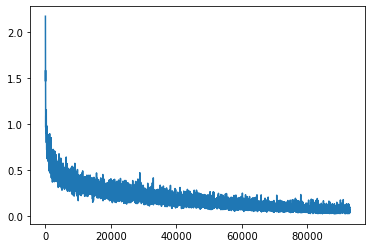

In [17]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label ,_,_,_,_ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
        netname='./weights/weights_face/face_0704_SGDmomentum_1e-5/epoch-{} loss-{}.pkl'.format(epoch, loss_contrastive.item())
    if((epoch%10==0) or (epoch == Config.train_number_epochs-1)):
        torch.save(net, netname, )
show_plot(counter,loss_history)

In [28]:
print(np.min(loss_history))

0.00481268810108304

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

In [ ]:
gn=0 #genuine matching 횟수
gns=0 #genuine matching 성공횟수
gnf=0
In=0 #imposter matching 횟수
ins=0 #imposter matching 성공횟수
inf=0
while True: #Genuine matching에 대해서만 출력
    try:
        x0,x1,label,x0_folder,x1_folder,x0_fname,x1_fname = next(dataiter)
    
        if (x1_folder==x0_folder): #genuine
            gn+=1
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            if (euclidean_distance<0.5):
                gns+=1

            else:
                gnf+=1
#                 concatenated = torch.cat((x0,x1),0)
#                 imshow(torchvision.utils.make_grid(concatenated),'distance: {:.2f}'.format(euclidean_distance.item()))
#                 print("왼쪽사진이름",x0_fname)
#                 print("오른쪽 사진이름" , x1_fname)
                
        elif(x1_folder!=x0_folder):
            In+=1
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            if (euclidean_distance>0.5):
                ins+=1
            else:
                inf+=1
        
    except:break
        
print ("genuine matching 횟수", gn)  
print ("imposter matching 횟수", In)
print ("genuine matching 성공횟수", gns)  
print ("imposter matching 성공횟수", ins)
print ("genuine matching 성공률(TP)", float(gns)/gn)
print ("imposter matching 성공률(TN)", float(ins)/In)
print ("genuine matching FP", inf/In)
print ("imposter matching FN", gnf/gn)
print (float(gns)/gn + gnf/gn)
          